In [11]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        
        self.decoder = decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [13]:
class AE(pl.LightningModule):
    def __init__(self, network):
        super().__init__()
        self.network = network
    
    
    def forward(self, x):
        return self.network(x)
    
    
    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        recon_imgs = self(imgs)
        loss = F.mse_loss(recon_imgs, imgs)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        recon_imgs = self(imgs)
        loss = F.mse_loss(recon_imgs, imgs)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.network.parameters(), lr=0.0002, betas=(0.9, 0.999))
        
        return optimizer


callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=5, dirpath='weights/VanillaAE', filename='VanillaAE-{epoch:03d}-{valid_loss:.4f}'),
]

    
network = AutoEncoder()
auto_encoder = AE(network)
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True, callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(auto_encoder, train_dataloader, valid_dataloader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/PapersWithCode_GenerativeModels/weights/VanillaAE exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type        | Params
----------------------------------------
0 | network | AutoEncoder | 454 K 
----------------------------------------
454 K     Trainable params
0         Non-trainable params
454 K     Total params
1.816     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

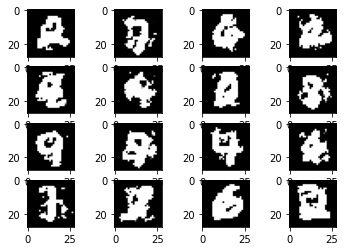

In [15]:
import random

idx = list(range(len(test_data.data)))
random.shuffle(idx)
idx = idx[:16]

test_samples = torch.flatten(test_data.data[idx].unsqueeze(1), start_dim=2).float()

ckpt_fname = "VanillaAE-epoch=029-valid_loss=0.0188.ckpt"
auto_encoder = auto_encoder.load_from_checkpoint("weights/VanillaAE/" + ckpt_fname, network=network)

samples = auto_encoder(test_samples).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()